# Do OpenPrescribing measures vary by software vendor?


In [84]:
from ebmdatalab.bq import cached_read
import pandas as pd
%matplotlib inline

In [85]:
# This CSV file was made from xls files we 
# were supplied by email, stitched together with 
# the `make_csv.py` script in the current directory
# The source files are currently stored at https://drive.google.com/drive/folders/1wiDcwTBwfAZ1_ELrdDx1Zm1JKOVBY9eQ
df = pd.read_csv('vendors.csv')

In [86]:
# Clean up the input data
df['Principal Supplier'] = df['Principal Supplier'].str.strip()
df.loc[df['Principal Supplier'] == 'INPS', 'Principal Supplier'] = 'Vision'  # seems they changed in 2017
df = df.loc[df['Date'] > '2016-02-01']  # there is some dirty data ("Unknowns") before this

# Overall market share

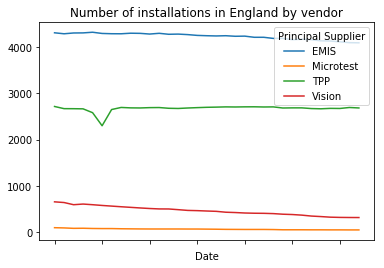

In [87]:
df.groupby(['Date','Principal Supplier'])['ODS'].count().unstack().plot.line(title="Number of installations in England by vendor")

# Geographic distribution

* EMIS is generally West coast and London
* TPP is generally East cost
* Microtest is basically Cornwall
* Vision is a bit random

This generally suggests we should exclude Microtest and Vision for confounders.

There may be London / geographic confounders for Emis and TPP too, which should be borne in mind

In [88]:
sql = """
WITH
  practice_count AS (
  SELECT
    ccg_id,
    COUNT(*) AS total_practices
  FROM
    hscic.practices
  WHERE
    setting = 4
    AND status_code = 'A'
  GROUP BY
    ccg_id)
SELECT
  TRIM(Principal_Supplier) AS supplier,
  practices.ccg_id AS pct,
  COUNT(*) AS count,
  total_practices
FROM
  hscic.vendors software
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  practice_count
ON
  practice_count.ccg_id = practices.ccg_id
WHERE
  practices.setting = 4
  AND practices.status_code = 'A'
  AND Date = '2018-11-01'
GROUP BY
  supplier,
  practices.ccg_id, total_practices
  """
by_ccg = cached_read(sql, csv_path="data/by_ccg.csv")

In [89]:
by_ccg['percent'] = (by_ccg['count'] / by_ccg['total_practices'] * 100).round()

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


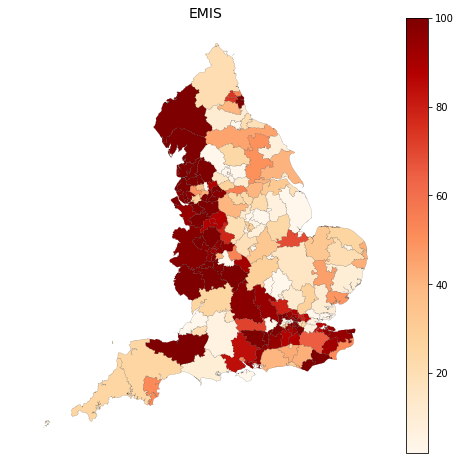

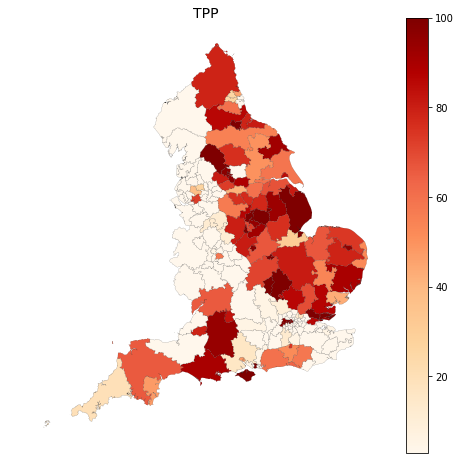

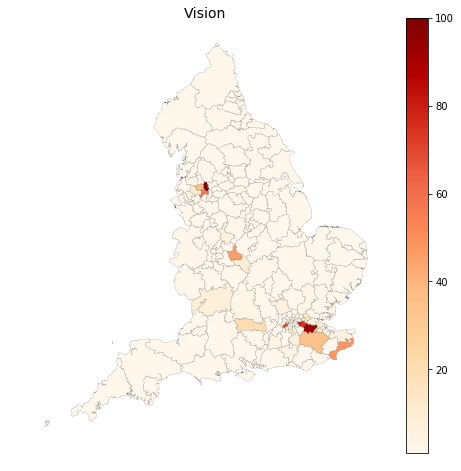

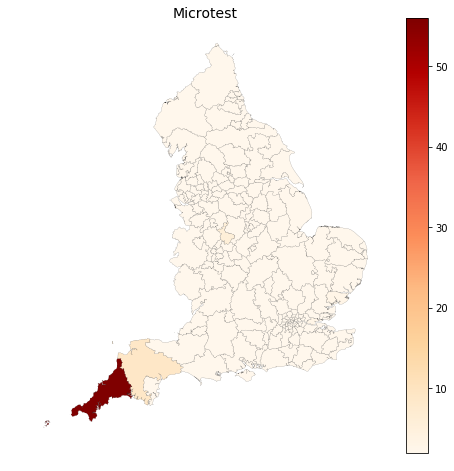

In [90]:
from ebmdatalab import maps
import importlib
importlib.reload(maps)
for supplier in by_ccg.supplier.unique():
    if not supplier:
        continue
    plt = maps.ccg_map(
        by_ccg[by_ccg['supplier'] == supplier], 
        title=supplier, column='percent', 
        separate_london=False)
    plt.show()

# Plotting trends

This doesn't give us a sense of the confidence in each trend-by-vendor, but plotting / computing without CI is fasters for eyeballing potentially interesting measures.  We then focus on others later.

Note that we're doing means here rather than medians (as on our website), just because compting confidence intervals in the later charts is easier that way. Therefore we trim practices with low practice sizes per [issue 323](https://github.com/ebmdatalab/openprescribing/issues/323) as outliers.

We can see that Microtest often comes out worse, but this is most likely confounded by Cornwallness.

In [93]:
from ebmdatalab import bq
import importlib
importlib.reload(bq)
measures = ['lyrica','icsdose','tramadol','ciclosporin','diltiazem','ktt9_cephalosporins_star',
            'lpzomnibus','ktt9_cephalosporins','ktt9_uti_antibiotics',
             'ghost_generic_measure',
            'ktt9_antibiotics','trimethoprim','keppra','statinintensity','tamoxifen',
            'glaucoma','ktt13_nsaids_ibuprofen','nebivolol','vitb',
            'other_lipid_modifying_drugs','test_strip','methotrexate','desogestrel',
            'pregabalin','bdzadq',
            'dipyridamole','doacs',
            'saba','fungal','glutenfree',
            'opioidspercent','ppi','opioidome','ace','pregabalinmg','silver',
            'opioidper1000','ktt12_diabetes_insulin','coproxamol',
            'bdzper1000','solublepara','ppidose','sildenafil','arb']

def get_data(measure_id):
    sql = """
SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  AVG(IEEE_DIVIDE(numerator, denominator)) AS calc_value,
  '{measure_id}' AS measure_id
FROM
  measures.practice_data_{measure_id} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100
  AND practices.status_code = 'A'
  AND denominator > 0
GROUP BY
  supplier,
  measure_id,
  m.month
ORDER BY
  month""".format(measure_id=measure_id)
    import pandas as pd
    df = bq.cached_read(sql, csv_path="data/{}_with_vendor.csv".format(measure_id), use_cache=False)
    return df


def get_dataframe(measures):
    df = pd.DataFrame()
    for measure in measures:
        df = df.append(get_data(measure))
    return df
df = get_dataframe(measures)

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


In [94]:
# Clean up the input data
import datetime
#df = df.loc[df['month'] > '2016-02-01']  # there is some dirty data ("Unknowns") before this
df = df[(df['supplier'] == 'EMIS') | (df['supplier'] == 'TPP')]
df.month = pd.to_datetime(df['month'])
df = df[df['month'] > '2016-02-01']

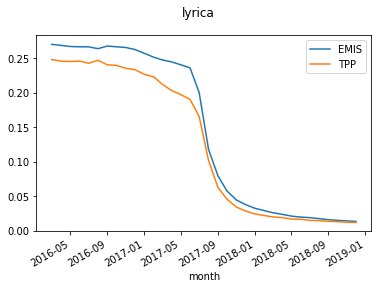

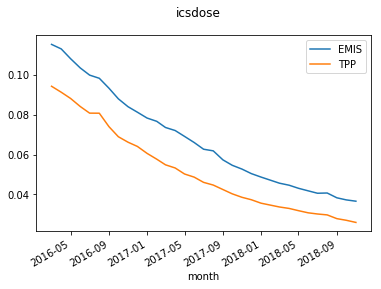

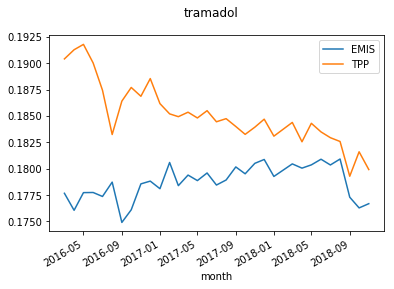

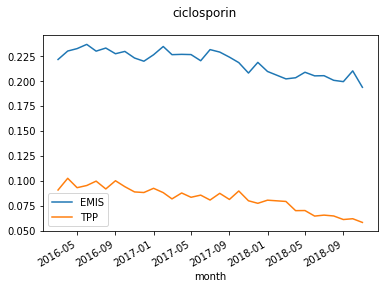

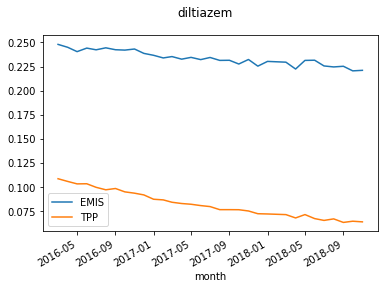

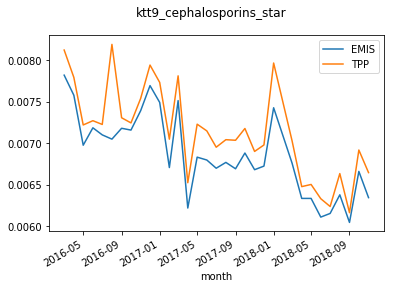

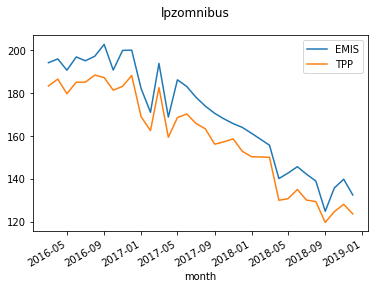

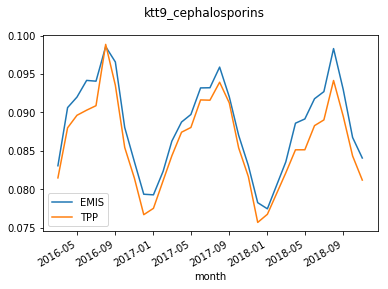

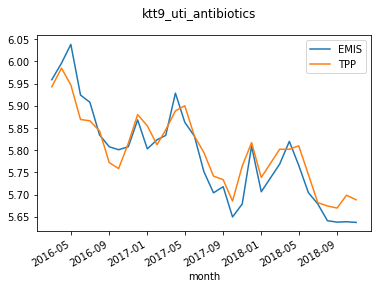

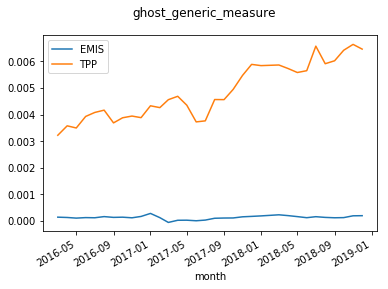

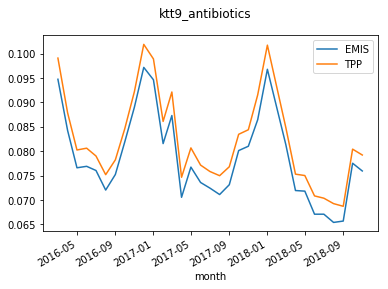

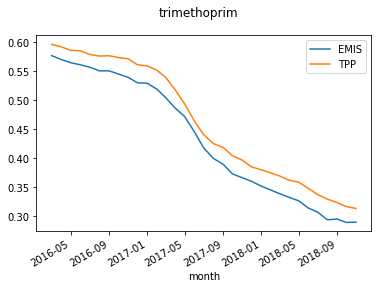

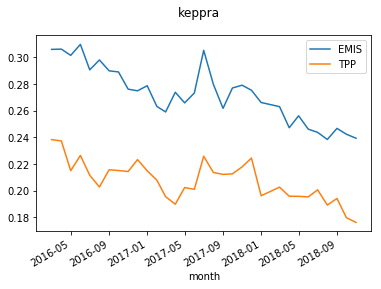

No handles with labels found to put in legend.


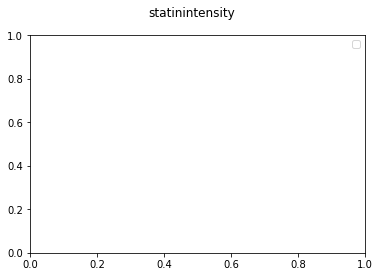

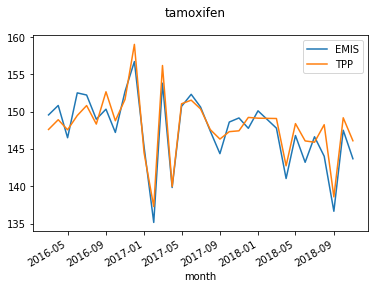

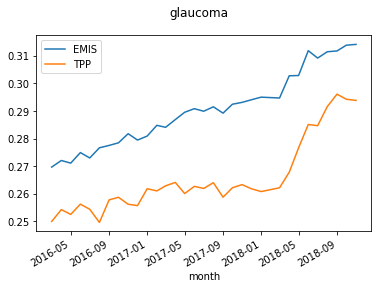

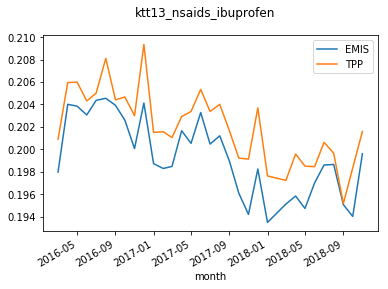

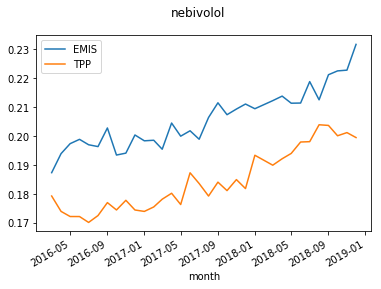

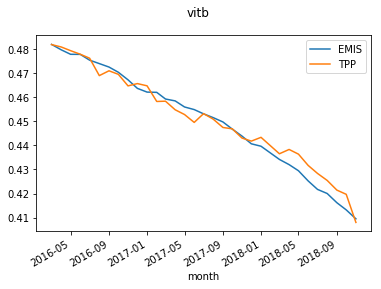

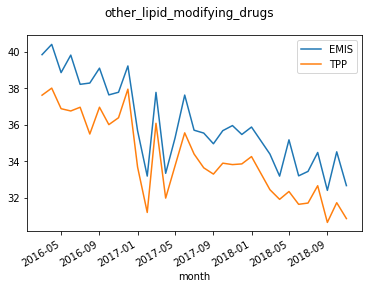

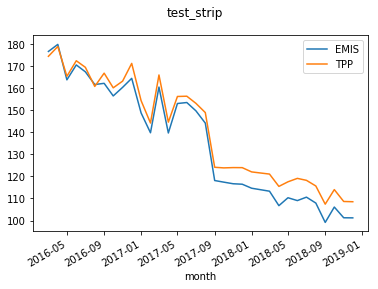

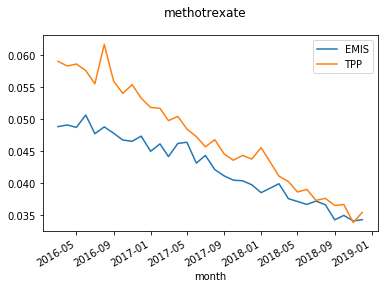

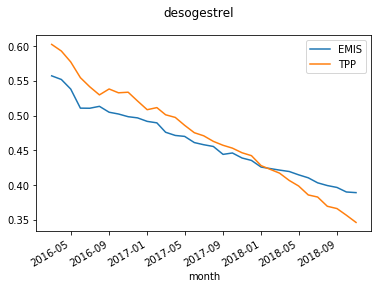

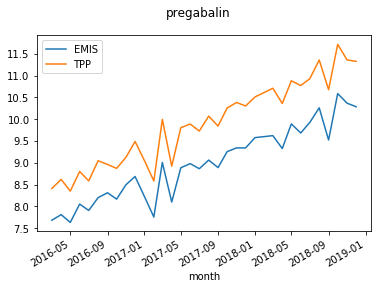

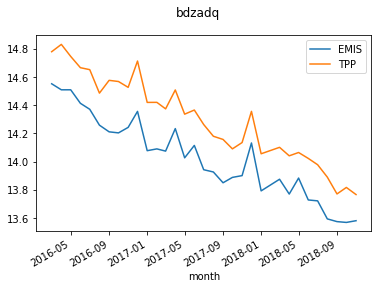

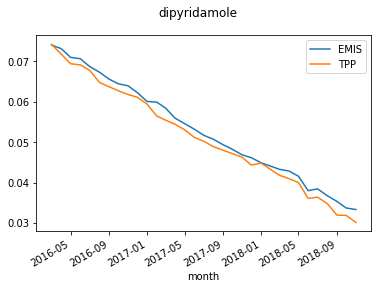

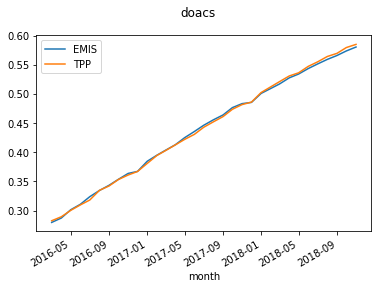

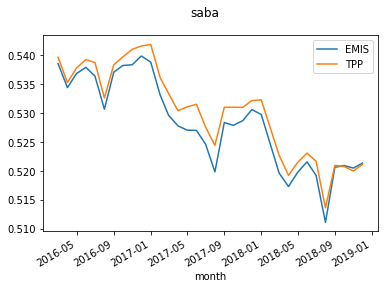

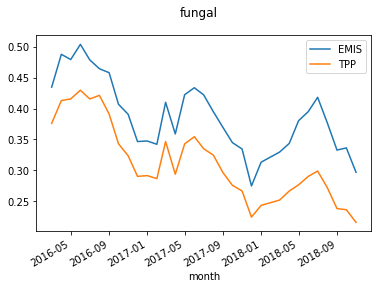

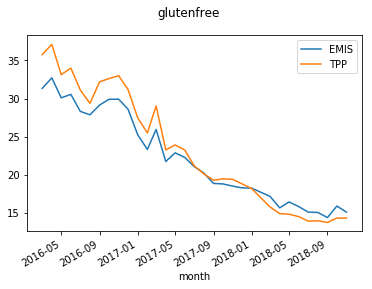

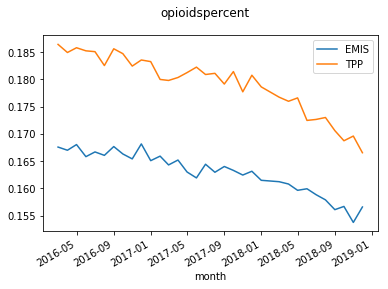

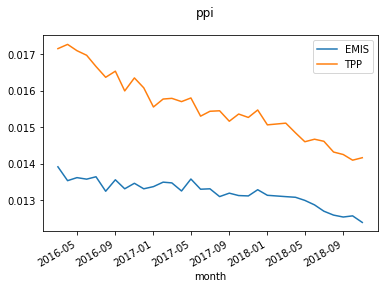

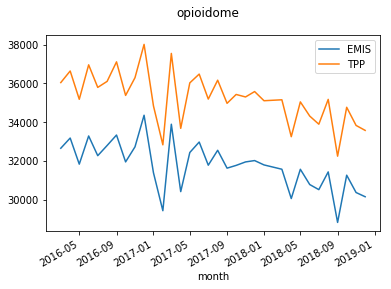

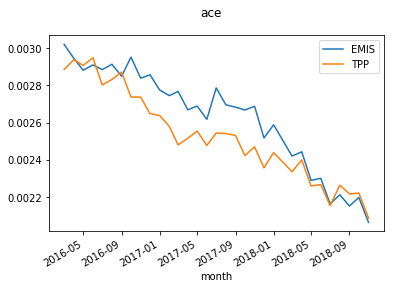

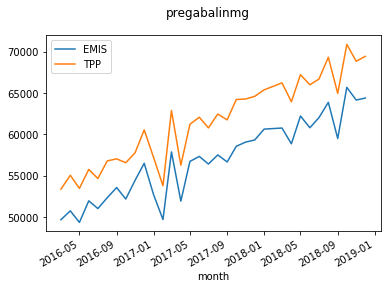

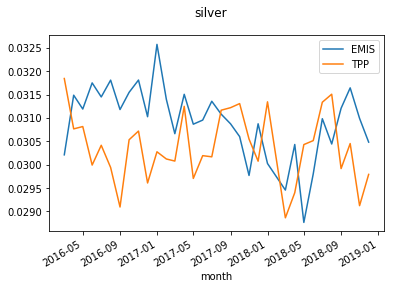

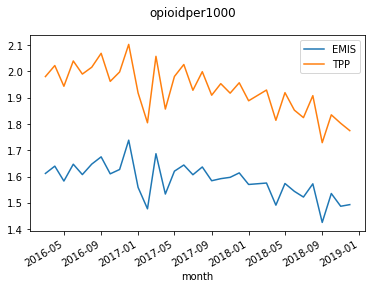

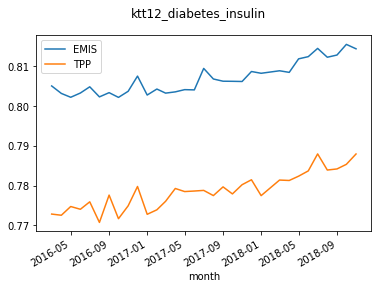

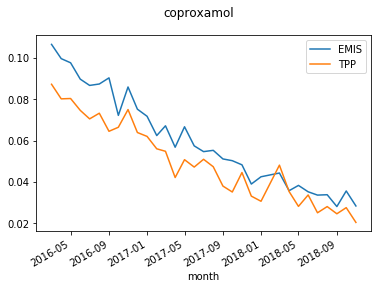

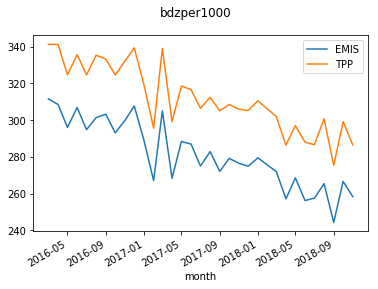

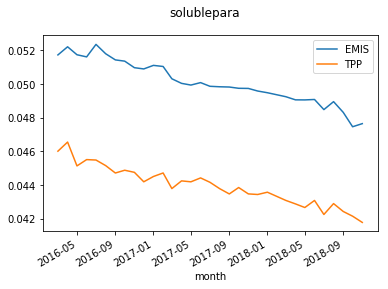

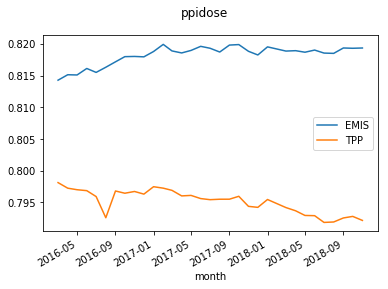

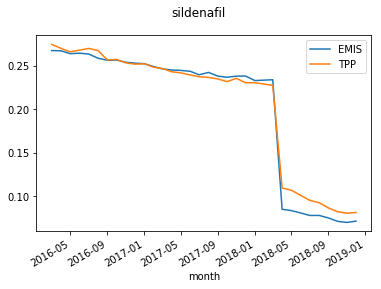

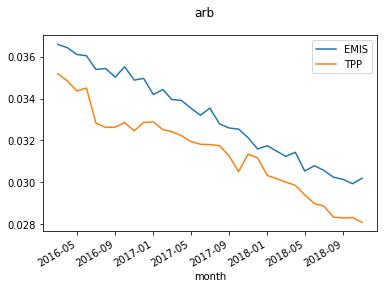

In [95]:
import numpy as np
import matplotlib.pyplot as plt
for measure in measures:
    fig, ax = plt.subplots()
    df2 = df[df['measure_id'] == measure]
    for key, grp in df2.groupby(['supplier']):
        ax = grp.plot(ax=ax, kind='line', x='month', y='calc_value', label=key)
    fig.suptitle(measure)
    plt.legend(loc='best')
    plt.show()

## Drill down to some interesting ones with confidence intervals

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)
/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


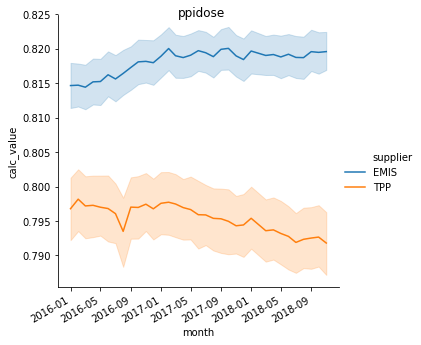

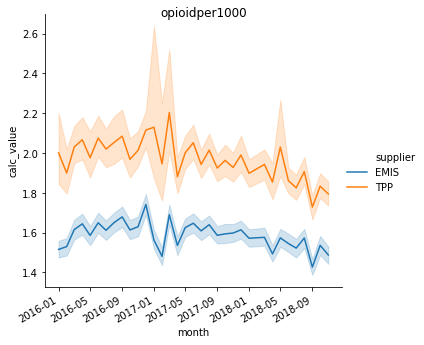

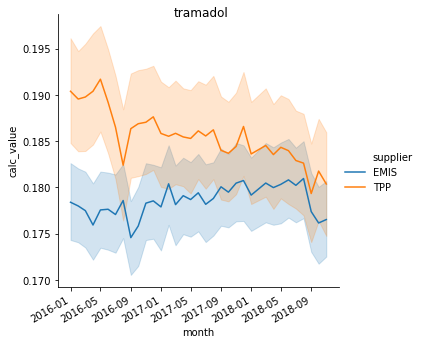

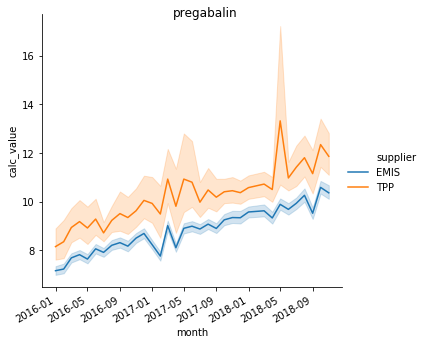

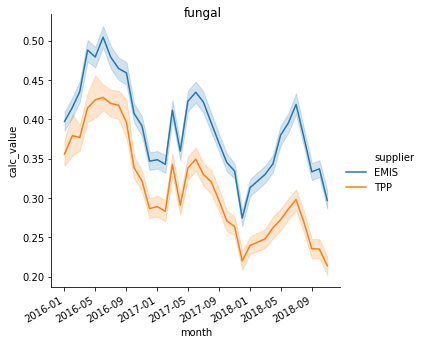

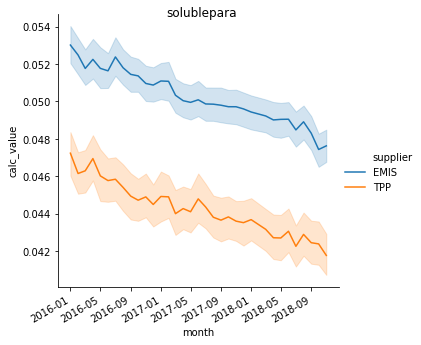

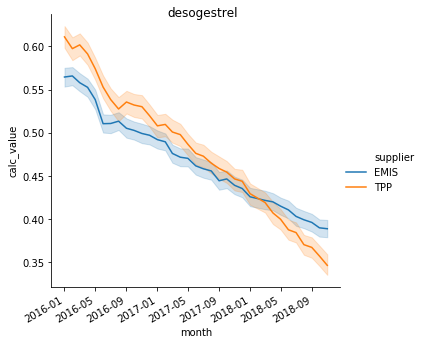

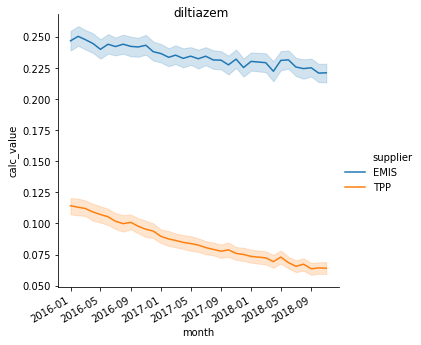

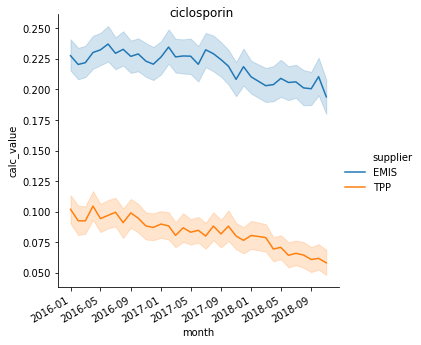

In [143]:
import seaborn as sns
interesting_measures = ['ppidose', 'opioidper1000', 'tramadol', 'pregabalin',
                        'fungal', 'solublepara', 
                        'desogestrel',
                        'diltiazem', 'ciclosporin', ]

%matplotlib inline
from ebmdatalab import bq
import importlib
importlib.reload(bq)
for measure_id in interesting_measures:
    sql = """SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  practice_id,
  IEEE_DIVIDE(numerator, denominator) AS calc_value
FROM
  measures.practice_data_{} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND software.Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND practices.status_code = 'A'
  AND total_list_size > 100 -- exclude non-standard practices
          AND TRIM(Principal_Supplier) = 'EMIS' OR TRIM(Principal_Supplier) = 'TPP'
        ORDER BY
          month""".format(measure_id)
    detailed = bq.cached_read(sql, csv_path="data/{}_detailed.csv".format(measure_id))
    detailed.month = pd.to_datetime(detailed['month'])
    sns.relplot(x="month", y="calc_value", hue='supplier', kind="line", data=detailed)
    fig = plt.gcf()
    fig.autofmt_xdate()
    fig.suptitle(measure_id) 
    plt.show()


## One of the above including all suppliers
While it's sensible to exclude low-volume suppliers, it's interesting to take a look at one of them anway:

In [84]:
sql = """SELECT
      TRIM(Principal_Supplier) AS supplier,
      month,
      IEEE_DIVIDE(numerator, denominator) AS calc_value
    FROM
      measures.practice_data_ppidose
    JOIN hscic.vendors software
    ON software.ODS = practice_id AND Date = month
    ORDER BY
      month"""
ppidose = cached_read(sql, csv_path="ppidose_detailed.csv")

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


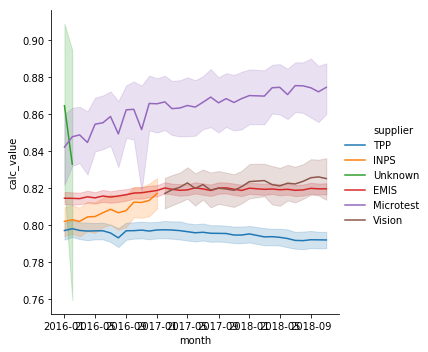

In [85]:
# But in this case the confidence intervals do not overlap...
import seaborn as sns
sns.relplot(x="month", y="calc_value", hue='supplier', kind="line", data=ppidose, title="ppidose")

# Generic prescribing
Finally, out of interest, and because this isn't already a measure, is there any difference in generic prescribing?  It doesn't really look  like it...

In [ ]:
sql = """  WITH num AS (
  SELECT
    month,
    practice,
    SUM(items) AS items
  FROM
    `ebmdatalab.hscic.normalised_prescribing_standard`
  WHERE
    bnf_code LIKE '_________AA%'
  GROUP BY
    month,
    practice),
  denom AS (
  SELECT
    month,
    practice,
    SUM(items) AS items
  FROM
    `ebmdatalab.hscic.normalised_prescribing_standard`
    --WHERE
    --  bnf_code LIKE '0%'
  GROUP BY
    month,
    practice),
  measure AS (
  SELECT
    num.month,
    num.practice,
    num.items AS numerator,
    denom.items AS denominator
  FROM
    num
  INNER JOIN
    denom
  ON
    num.month = denom.month AND num.practice = denom.practice)
SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.month,
  AVG(IEEE_DIVIDE(numerator,
    denominator)) AS calc_value
FROM
  measure m
JOIN
  hscic.vendors software
ON
  software.ODS = practice
  AND software.Date = DATE(m.month)
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND practices.status_code = 'A'
  AND total_list_size > 100 -- exclude non-standard practices
  AND TRIM(Principal_Supplier) = 'EMIS'
  OR TRIM(Principal_Supplier) = 'TPP'
GROUP BY supplier, month  
  """
gdf = bq.cached_read(sql, csv_path="data/generics_detailed.csv")

In [152]:
gdf.head()

,supplier,month,calc_value
0,EMIS,2017-07-01,0.809027
1,EMIS,2016-03-01,0.816784
2,EMIS,2018-01-01,0.808187
3,EMIS,2016-12-01,0.813782
4,TPP,2016-02-01,0.813581


In [ ]:
gdf.month = pd.to_datetime(gdf['month'])
sns.relplot(x="month", y="calc_value", hue='supplier', kind="line", data=gdf)
fig = plt.gcf()
fig.autofmt_xdate()
fig.suptitle("Generic as proportion of all prescribing") 
plt.show()